<a href="https://colab.research.google.com/github/CSSamarasinghe/SE4050_Assignment/blob/IT21263194/Model_change_to_keras_improvement1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'amazon-reviews-for-sentianalysis-finegrained-csv:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2078107%2F3499094%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241003%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241003T164549Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D25a30a2ad799910d48f45f67793fb1d09f31560ae3773fa14870108018fa213261ae62aeb020867952a30d8094a21359c2546a6475193ac986bc2645a191d848c7223dbd5c68600aeb8f17d5a979be9750827328816b6743cf0d74ca79e5a28878f8606f4d3cd2176678d18b8a70a20bbf9be8037aa238d4b56bd1a0ba1a8d1fb4003bbd12f51fa6d438aaa8a7e8fa90a9291e62969f7df78c34dc6a71c76fb2f1c11e2964127136ec4d5554e9f1bdd7c530f8ddf987a08dd6cb91a849e4e98a2089149d22cb00ca687688c756071af4270e392fd79699c1f4a35ca16597523ca8bfe37fea11d5911465ea51d6eb17c1e3663da806763c8ef4e96e1f0a9ae9ab'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 654512809 bytes downloaded
Downloaded and uncompressed: amazon-reviews-for-sentianalysis-finegrained-csv
Data source import complete.


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load and preprocess data
train_data = pd.read_csv('../input/amazon-reviews-for-sentianalysis-finegrained-csv/amazon_review_fine-grained_5_classes_csv/train.csv')
test_data = pd.read_csv('../input/amazon-reviews-for-sentianalysis-finegrained-csv/amazon_review_fine-grained_5_classes_csv/test.csv')

# Sample the dataset for manageable size (adjust as necessary)
train_data = train_data.sample(n=80000, random_state=42)
test_data = test_data.sample(n=35000, random_state=42)

# Initialize the tokenizer and fit on training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['review_text'])

# Convert text to sequences
X_train = tokenizer.texts_to_sequences(train_data['review_text'])
X_test = tokenizer.texts_to_sequences(test_data['review_text'])

# Pad sequences to ensure uniform input size
max_length = max(max(len(seq) for seq in X_train), max(len(seq) for seq in X_test))
X_train_padded = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test, maxlen=max_length, padding='post')

# Prepare labels (keep them as integers)
Y_train = train_data['class_index'].values -1
Y_test = test_data['class_index'].values -1

# Split the entire dataset into training (60%), validation (20%), and test (20%)
X_train_temp, X_val, y_train_temp, y_val = train_test_split(
    X_train_padded, Y_train, test_size=0.2, random_state=42, stratify=Y_train)

X_train, X_test_final, y_train, y_test_final = train_test_split(
    X_train_temp, y_train_temp, test_size=0.25, random_state=42)  # 0.25 of 80% is 20%

# Further split the training data into four parts
X_train_first, X_train_second, y_train_first, y_train_second = train_test_split(
    X_train, y_train, test_size=0.5, random_state=42)

X_train_third, X_train_fourth, y_train_third, y_train_fourth = train_test_split(
    X_train_second, y_train_second, test_size=0.5, random_state=42)

# Output the shapes to verify the splits
print("Training Data Shapes:")
print("X_train_first shape:", X_train_first.shape)
print("y_train_first shape:", y_train_first.shape)
print("X_train_second shape:", X_train_second.shape)
print("y_train_second shape:", y_train_second.shape)
print("X_train_third shape:", X_train_third.shape)
print("y_train_third shape:", y_train_third.shape)
print("X_train_fourth shape:", X_train_fourth.shape)
print("y_train_fourth shape:", y_train_fourth.shape)

print("\nValidation Data Shape:")
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

print("\nTest Data Shape:")
print("X_test_final shape:", X_test_final.shape)
print("y_test_final shape:", y_test_final.shape)

# Convert NumPy arrays to Pandas DataFrames for easier inspection (optional)
df1 = pd.DataFrame(X_train_first)
df2 = pd.DataFrame(X_train_second)
df3 = pd.DataFrame(X_train_third)
df4 = pd.DataFrame(X_train_fourth)

# Display the first few rows of each DataFrame (optional)
print("\nFirst subset of training data:")
print(df1.head())
print("\nSecond subset of training data:")
print(df2.head())
print("\nThird subset of training data:")
print(df3.head())
print("\nFourth subset of training data:")
print(df4.head())


Training Data Shapes:
X_train_first shape: (24000, 215)
y_train_first shape: (24000,)
X_train_second shape: (24000, 215)
y_train_second shape: (24000,)
X_train_third shape: (12000, 215)
y_train_third shape: (12000,)
X_train_fourth shape: (12000, 215)
y_train_fourth shape: (12000,)

Validation Data Shape:
X_val shape: (16000, 215)
y_val shape: (16000,)

Test Data Shape:
X_test_final shape: (16000, 215)
y_test_final shape: (16000,)

First subset of training data:
     0     1     2     3      4      5    6     7     8    9    ...  205  206  \
0      2    45     1  1223     11  35652    3    31  3817   31  ...    0    0   
1      2    71  1481  1744     27      2  167  2109    18    1  ...    0    0   
2      2    33   347     1  53017     22    4   470     3   29  ...    0    0   
3      2    20    84     4   8510   7183  212    11     4  151  ...    0    0   
4  18661  8622  5303   620    107     20    4    91    78   65  ...    0    0   

   207  208  209  210  211  212  213  214  
0  

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, GlobalMaxPool1D, Dense
from tensorflow.keras.optimizers import Adam

# Define model parameters
embedding_dim = 200  # GloVe embedding dimension
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
max_length = X_train_first.shape[1]  # Sequence length

# Initialize the model
model = Sequential()

# Embedding layer initialized with GloVe embeddings (weights need to be defined)
embedding_matrix = np.zeros((vocab_size, embedding_dim))  # Initialize embedding matrix

model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=max_length,
                    weights=[embedding_matrix],
                    trainable=True))  # Set trainable=False to freeze GloVe weights

# First Bidirectional LSTM layer
model.add(Bidirectional(LSTM(64, return_sequences=True)))
# Second Bidirectional LSTM layer (returning the full sequence)
model.add(Bidirectional(LSTM(64, return_sequences=True)))
# Dropout layer to prevent overfitting
model.add(Dropout(0.5))
# Global Max Pooling layer for dimensionality reduction
model.add(GlobalMaxPool1D())
# Output layer for classification into 5 classes (rating from 1 to 5)
model.add(Dense(5, activation='softmax'))

# Compile the model with categorical crossentropy for classification
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │      22,384,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,384,400 (85.39 MB)

 Trainable params: 22,384,400 (85.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
94/94 ━━━━━━━━━━━━━━━━━━━━ 349s 4s/step - accuracy: 0.2654 - loss: 1.5773 - val_accuracy: 0.4325 - val_loss: 1.3604
Epoch 2/2
94/94 ━━━━━━━━━━━━━━━━━━━━ 385s 4s/step - accuracy: 0.5082 - loss: 1.1500 - val_accuracy: 0.4640 - val_loss: 1.2713
Epoch 1/2
94/94 ━━━━━━━━━━━━━━━━━━━━ 347s 4s/step - accuracy: 0.4695 - loss: 1.2156 - val_accuracy: 0.4798 - val_loss: 1.2585
Epoch 2/2
94/94 ━━━━━━━━━━━━━━━━━━━━ 371s 4s/step - accuracy: 0.6177 - loss: 0.9266 - val_accuracy: 0.4709 - val_loss: 1.2224
Epoch 1/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 206s 4s/step - accuracy: 0.7689 - loss: 0.6341 - val_accuracy: 0.4431 - val_loss: 1.2752
Epoch 2/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 254s 4s/step - accuracy: 0.8667 - loss: 0.3856 - val_accuracy: 0.4400 - val_loss: 1.3494
Epoch 1/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 195s 4s/step - accuracy: 0.7188 - loss: 0.7124 - val_accuracy: 0.4556 - val_loss: 1.2644
Epoch 2/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 192s 4s/step - accuracy: 0.8711 - loss: 0.3789 - val_accuracy: 0.4360 - val_loss:

ValueError: x and y must have same first dimension, but have shapes (4,) and (2,)

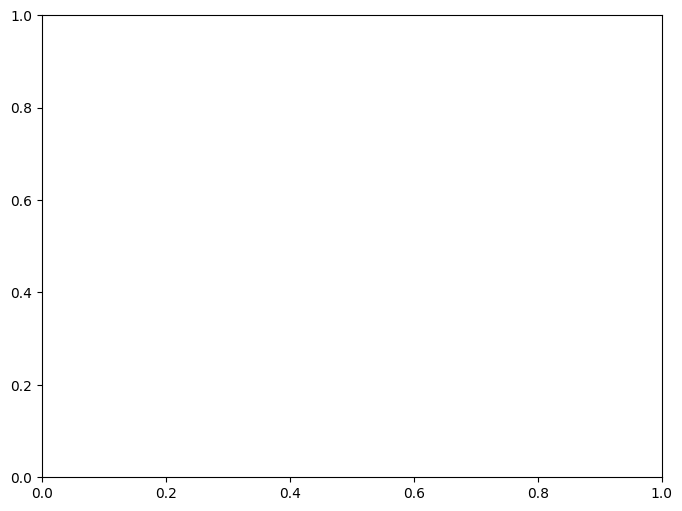

In [15]:
import matplotlib.pyplot as plt

# Placeholder for accuracy values from each subset training
all_train_accuracies = []
all_val_accuracies = []

# Train model with the first subset
history1 = model.fit(X_train_first, y_train_first, validation_data=(X_val, y_val), epochs=2, batch_size=256, verbose=1)
all_train_accuracies.append(history1.history['accuracy'])
all_val_accuracies.append(history1.history['val_accuracy'])

# Train model with the second subset
history2 = model.fit(X_train_second, y_train_second, validation_data=(X_val, y_val), epochs=2, batch_size=256, verbose=1)
all_train_accuracies.append(history2.history['accuracy'])
all_val_accuracies.append(history2.history['val_accuracy'])

# Train model with the third subset
history3 = model.fit(X_train_third, y_train_third, validation_data=(X_val, y_val), epochs=2, batch_size=256, verbose=1)
all_train_accuracies.append(history3.history['accuracy'])
all_val_accuracies.append(history3.history['val_accuracy'])

# Train model with the fourth subset
history4 = model.fit(X_train_fourth, y_train_fourth, validation_data=(X_val, y_val), epochs=2, batch_size=256, verbose=1)
all_train_accuracies.append(history4.history['accuracy'])
all_val_accuracies.append(history4.history['val_accuracy'])




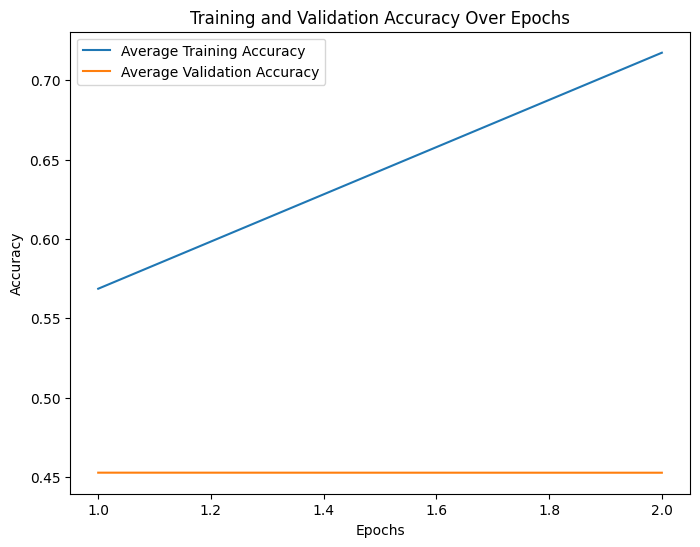

In [19]:
# Compute the average accuracy over all subsets
average_train_accuracy = np.mean(all_train_accuracies, axis=0)
average_val_accuracy = np.mean(all_val_accuracies, axis=0)

# Plot the average accuracies
epochs_range = range(1, 2 + 1)  # Assuming 3 epochs

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, average_train_accuracy, label='Average Training Accuracy')
plt.plot(epochs_range, average_val_accuracy, label='Average Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
import numpy as np

# Get the last epoch accuracy for each subset (for both training and validation)
final_train_accuracies = [history.history['accuracy'][-1] for history in [history1, history2, history3, history4]]
final_val_accuracies = [history.history['val_accuracy'][-1] for history in [history1, history2, history3, history4]]

# Calculate the total average accuracy
total_train_accuracy = np.mean(final_train_accuracies)
total_val_accuracy = np.mean(final_val_accuracies)

print(f"Total Training Accuracy: {total_train_accuracy * 100:.2f}%")
print(f"Total Validation Accuracy: {total_val_accuracy * 100:.2f}%")


Total Training Accuracy: 71.73%
Total Validation Accuracy: 45.27%


In [22]:
# Evaluate the model on the final test dataset
test_loss, test_accuracy = model.evaluate(X_test_final, y_test_final, verbose=1)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


500/500 ━━━━━━━━━━━━━━━━━━━━ 87s 174ms/step - accuracy: 0.4475 - loss: 1.3363
Test Accuracy: 44.27%


In [18]:
print(all_train_accuracies)

[[0.320250004529953, 0.5141249895095825], [0.4704166650772095, 0.6179583072662354], [0.7620833516120911, 0.8665833473205566], [0.721750020980835, 0.8705000281333923]]


In [16]:
print(average_val_accuracy)

[0.45275    0.45271874]


In [17]:
print(average_train_accuracy)

[0.56862501 0.71729167]
